Importation et Installation 

In [ ]:
!pip install dgl -f https://data.dgl.ai/wheels/repo.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.dgl.ai/wheels/repo.html


In [ ]:
import numpy as np
import torch
import dgl
import dgl.function as fn
import networkx as nx
import torch.nn as nn
import torch.nn.functional as F
import itertools
import numpy as np
import scipy.sparse as sp
from sklearn.metrics import *


# Dataset : 

Les données Facebook ont été collectées auprès des participants à l'enquête en utilisant l'application Facebook. Le jeu de données comprend des caractéristiques de nœuds (profils), des cercles listes d'amis) et des réseaux d'ego. 
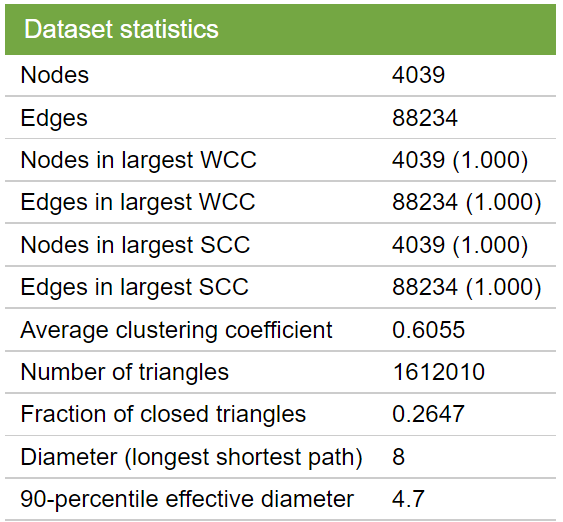


In [ ]:
!wget http://snap.stanford.edu/data/facebook.tar.gz
!tar -xvf "facebook.tar.gz"

--2023-01-14 22:08:52--  http://snap.stanford.edu/data/facebook.tar.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 732104 (715K) [application/x-gzip]
Saving to: ‘facebook.tar.gz.1’

facebook.tar.gz.1   100%[===================>] 714.95K   470KB/s    in 1.5s    

2023-01-14 22:08:54 (470 KB/s) - ‘facebook.tar.gz.1’ saved [732104/732104]

facebook/
facebook/3980.egofeat
facebook/0.featnames
facebook/698.egofeat
facebook/3437.feat
facebook/3980.featnames
facebook/0.edges
facebook/3437.circles
facebook/686.circles
facebook/348.egofeat
facebook/107.feat
facebook/348.feat
facebook/1912.circles
facebook/3437.egofeat
facebook/698.feat
facebook/348.edges
facebook/1912.feat
facebook/414.circles
facebook/1684.egofeat
facebook/1684.featnames
facebook/1684.feat
facebook/107.egofeat
facebook/0.circles
facebook/414.edges
facebook/698.featnames
f

**ID :**  correspond au préfixe du nom du fichier

In [ ]:
file_edges = f'facebook/0.edges'
file_feat = f'facebook/0.feat'
edges_u, edges_v = [], []
# load edges file
with open(file_edges) as f:  
    for line in f:
        e1, e2 = tuple(int(x) - 1 for x in line.split())
        edges_u.append(e1)
        edges_v.append(e2)
edges_u=np.array(edges_u)
edges_v =np.array(edges_v)
num_nodes = 0  # suppose que les nœuds sont séquentiels
feats = []  # node features
# charger le fichier des caractéristiques du noeud
with open(file_feat) as f:  
    for line in f:
        num_nodes += 1
        a = [int(x) for x in line.split()[1:]]  # La 0ème entrée est l'identifiant du noeud
        feats.append(torch.tensor(a, dtype=torch.float))

feats = torch.stack(feats)
g = dgl.graph((edges_u, edges_v))  # construire un graphique
g.ndata['feat'] = feats

g  # Afficher les métadonnées du graphique

Graph(num_nodes=347, num_edges=5038,
      ndata_schemes={'feat': Scheme(shape=(224,), dtype=torch.float32)}
      edata_schemes={})

In [ ]:
!pip install pyg-nightly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


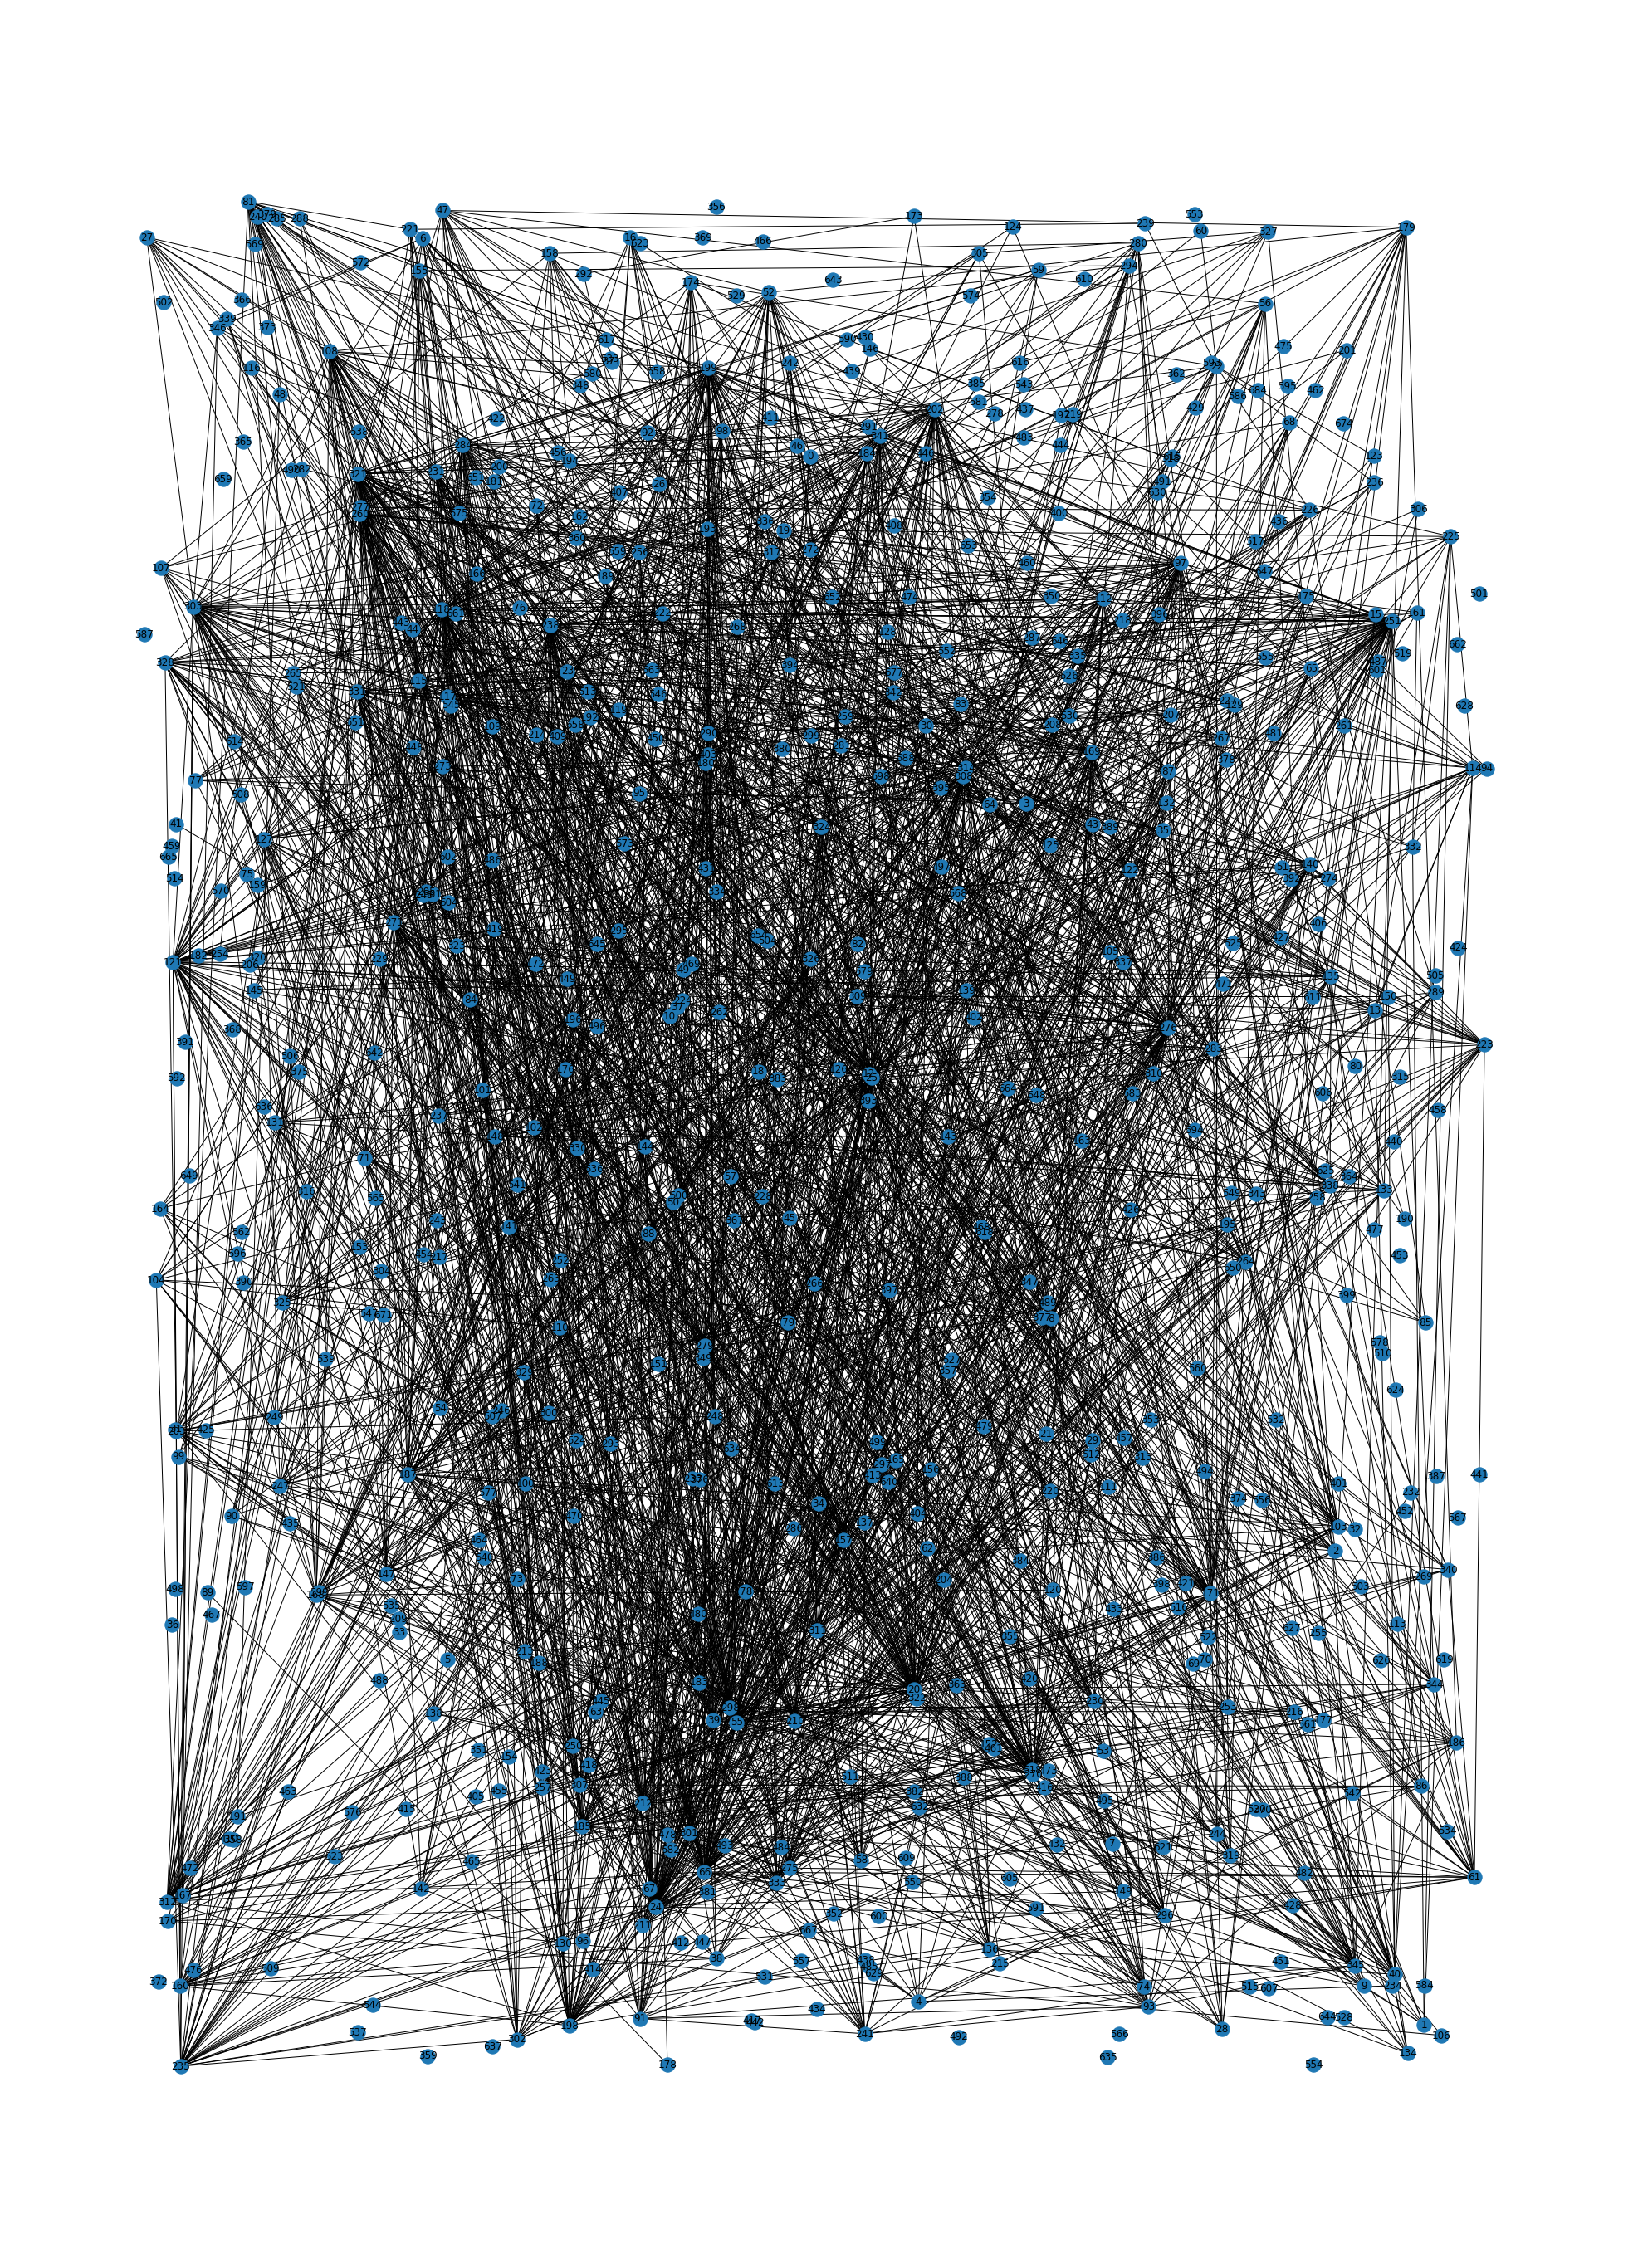

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
G = nx.Graph()
fig, ax = plt.subplots(figsize=(50,50))
G.add_nodes_from(set(edges_u + edges_v))
G.add_edges_from(zip(edges_u, edges_v))
nx.draw_random(G, with_labels = True)
plt.savefig("filename3.png")


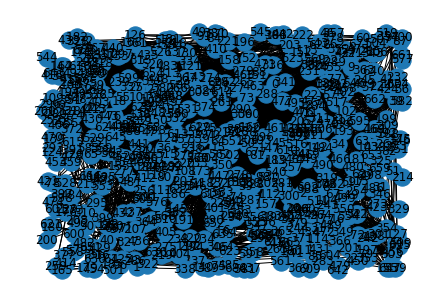

In [ ]:
nx.draw_random(G, with_labels = True)

**Split Data** :Une fois le graphe construit, nous pouvons le diviser en un ensemble d'apprentissage et un ensemble de test.

In [ ]:
TEST_RATIO = 0.3  # ratio pour la division de l'ensemble de test

u, v = g.edges()

eids = np.arange(g.number_of_edges())
eids = np.random.permutation(eids)
test_size = int(len(eids) * 0.3)  # nombre d'arêtes dans l'ensemble de test
train_size = g.number_of_edges() - test_size  # nombre d'arêtes dans l'ensemble de formation

# obtenir des bords positifs pour le test et le train
test_pos_u, test_pos_v = u[eids[:test_size]], v[eids[:test_size]]
train_pos_u, train_pos_v = u[eids[test_size:]], v[eids[test_size:]]

# Trouver tous les bords négatifs
adj = sp.coo_matrix((np.ones(len(u)), (u.numpy(), v.numpy())))
adj_neg = 1 - adj.todense() - np.eye(g.number_of_nodes())
neg_u, neg_v = np.where(adj_neg != 0)

# diviser les bords négatifs pour la formation et le test 
neg_eids = np.random.choice(len(neg_u), g.number_of_edges())
test_neg_u, test_neg_v = neg_u[neg_eids[:test_size]], neg_v[neg_eids[:test_size]]
train_neg_u, train_neg_v = neg_u[neg_eids[test_size:]], neg_v[neg_eids[test_size:]]

# construire des graphiques positifs et négatifs pour  l'entraînement et les tests
train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=g.number_of_nodes())
train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=g.number_of_nodes())

test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=g.number_of_nodes())
test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=g.number_of_nodes())

# graphique d'entraînement
train_g = dgl.remove_edges(g, eids[:test_size])
train_g = dgl.add_self_loop(train_g)


**Définition du modèle :** nous construisons le modèle à partir de l'implémentation existante dans la bibliothèque DGL.

**Le GCN** est un réseau convolutif de graphes standard.
Nous définissons également le DotPredictor, qui permet de prédire la probabilité de l'existence ou non d'un bord.

**DotPredictor :** Nous définissons également le prédicteur DotPredictor, qui nous permet de prédire la probabilité de l'existence ou non du likelihood.

In [ ]:
from dgl.nn import GraphConv
class GCN(nn.Module):
    def __init__(self, in_feats, h_feats):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, h_feats)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

class DotPredictor(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            # Calculez une nouvelle caractéristique d'arête nommée "score" par un produit scalaire entre les éléments suivants
            # caractéristique du noeud source 'h' et caractéristique du noeud de destination 'h'.
            g.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            # u_dot_v renvoie un vecteur à 1 élément pour chaque bord, vous devez donc le comprimer.
            return g.edata['score'][:, 0]

**Training and testing**

In [ ]:
def compute_loss(pos_score, neg_score): 
  scores = torch.cat([pos_score, neg_score])
  labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])])
  return F.binary_cross_entropy_with_logits(scores, labels)

def compute_auc(pos_score, neg_score):  
  scores = torch.cat([pos_score, neg_score]).numpy()
  labels = torch.cat(
  [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy()
  return roc_auc_score(labels, scores)

In [ ]:
model = GCN(train_g.ndata['feat'].shape[1], 16)
pred = DotPredictor()
optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)
all_logits = []
for e in range(100):
   # forward
   h = model(train_g, train_g.ndata['feat'])  # get node embeddings
   pos_score = pred(train_pos_g, h)
   neg_score = pred(train_neg_g, h)
   loss = compute_loss(pos_score, neg_score)
   # backward
   optimizer.zero_grad()
   optimizer.step()
   if e % 5 == 0:
     print('In epoch {}, loss: {}'.format(e, loss))


In epoch 0, loss: 0.6578200459480286
In epoch 5, loss: 0.6578200459480286
In epoch 10, loss: 0.6578200459480286
In epoch 15, loss: 0.6578200459480286
In epoch 20, loss: 0.6578200459480286
In epoch 25, loss: 0.6578200459480286
In epoch 30, loss: 0.6578200459480286
In epoch 35, loss: 0.6578200459480286
In epoch 40, loss: 0.6578200459480286
In epoch 45, loss: 0.6578200459480286
In epoch 50, loss: 0.6578200459480286
In epoch 55, loss: 0.6578200459480286
In epoch 60, loss: 0.6578200459480286
In epoch 65, loss: 0.6578200459480286
In epoch 70, loss: 0.6578200459480286
In epoch 75, loss: 0.6578200459480286
In epoch 80, loss: 0.6578200459480286
In epoch 85, loss: 0.6578200459480286
In epoch 90, loss: 0.6578200459480286
In epoch 95, loss: 0.6578200459480286


In [ ]:
  # ----------- test and check results ---------------- #
  
with torch.no_grad():
  pos_score = pred(test_pos_g, h)
  neg_score = pred(test_neg_g, h)
  print('AUC', compute_auc(pos_score, neg_score))


AUC 0.8190087165770014


**Friend recommendation**

In [ ]:
# --------- Générer une recommandation pour l'utilisateur -------- #
def generate_rec(h, user_id=0):
    # `h` représente l'encastrement des nœuds, avec la forme [num_nodes, hidden_size]

    # générer un graphe avec des arêtes (num_nodes - num_friends_of_user)
    # une extrémité de l'arête est l'utilisateur_id
    # l'autre extrémité est un utilisateur qui n'est PAS ami avec user_id
    user_friends = set()
    user_neg_u, user_neg_v = [], []
    for n1, n2 in zip(u, v):   # obtenir tous les amis de user_id
        if int(n1) == user_id:
            user_friends.add(int(n2))
        if int(n2) == user_id:
            user_friends.add(int(n1))

    for i in range(num_nodes):  # générer des "bords négatifs" pour user_id
        if i != user_id and i not in user_friends:
            user_neg_u.append(user_id)
            user_neg_v.append(i)
            
    user_g = dgl.graph((user_neg_u, user_neg_v), num_nodes=g.number_of_nodes())

    pred = DotPredictor()

    # calculer le score de chaque utilisateur
    scores = [(i, score) for i, score in enumerate(pred(user_g, h))]

    # produire la liste finale classée
    scores.sort(key=lambda x: -x[1])

    # afficher les résultats
    print(f"List of 5 suggested friends for user {user_id}:")
    for i in range(5):
        print(f'- User {scores[i][0]}, score = {scores[i][1]}')


In [ ]:
generate_rec(h, user_id=6)

List of 5 suggested friends for user 6:
- User 29, score = 0.8993791937828064
- User 111, score = 0.7381545901298523
- User 37, score = 0.6886093616485596
- User 33, score = 0.673736035823822
- User 22, score = 0.6732965707778931
